In [5]:
nn = xr.open_dataset('data/ice_2015_nn.nc')
int = xr.open_dataset('data/ice_2015.nc')
np.nanmax(nn.U[20,:,:] - int.U[20,:,:])

0.0

In [2]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import os
from pathlib import Path
from lkf_tools.dataset import *
import dill
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
lkf_data = process_dataset('./data/ice_2015.nc', output_path='./lkfs/dog005/',
                          dog_thres=0.05, t_red=1)

  -->  Compute dxu and dyu from lon,lat using SSMI projection


In [25]:
%%time
lkf_data.detect_lkfs(indexes=[0,1])

Compute deformation rates and detect features for day 1
Start detection routines
Compute deformation rates and detect features for day 2
Start detection routines
CPU times: user 3.9 s, sys: 49.3 ms, total: 3.95 s
Wall time: 3.56 s


In [26]:
dill.dump(lkf_data, file = open("lkf_pickle_files/lkf_data_2015_005.pickle", "wb"))

In [27]:
#lkf_data_2015_nn_005 = dill.load(open("lkf_pickle_files/lkf_data_2015_nn_005.pickle", "rb"))
lkf_data_2015_005 = dill.load(open("lkf_pickle_files/lkf_data_2015_005.pickle", "rb"))

In [28]:
lkf_data = lkf_data_2015_005

In [29]:
# lkf_data.indexes are the indices entered in the detect_lkfs(indexes=...) function
it = lkf_data.indexes[0]

# the path where the lkfs of one lkf_data file are saved is set in the
# process_dataset function:
# lkf_data = process_dataset('./data/ice_2015.nc', output_path='./lkfs/')
# => lkfs/ice_2015/lkf_ice_2015_day.npy
# with the day being the index + 1 (i.e. it+1)
path_to_file = lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+1)))

# load the lkfs
lkfs = np.load(path_to_file ,allow_pickle=True)

day = 1
lkf_number = 3
print(f'''number of lkfs at day {day}: {np.shape(lkfs)}
lkf number {lkf_number} is stored as {np.shape(lkfs[lkf_number+1])} shaped array
{np.shape(lkfs[lkf_number+1])[0]} is the pixel length of the lkf
it has {np.shape(lkfs[lkf_number+1])[1]} attributes like longitude and latitude,
stored in the [:,2] and [:,3] position, respectively''')

number of lkfs at day 1: (90,)
lkf number 3 is stored as (32, 7) shaped array
32 is the pixel length of the lkf
it has 7 attributes like longitude and latitude,
stored in the [:,2] and [:,3] position, respectively


In [32]:
lkfs_all = []
for it in lkf_data.indexes:
    path_to_file = lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+1)))
    lkfs_all.append(np.load(path_to_file, allow_pickle=True))
    
print('day   number of lkfs')
for ind, item in enumerate(lkfs_all):
    print(ind+1, '   ', np.shape(item)[0])

day   number of lkfs
1     90
2     63


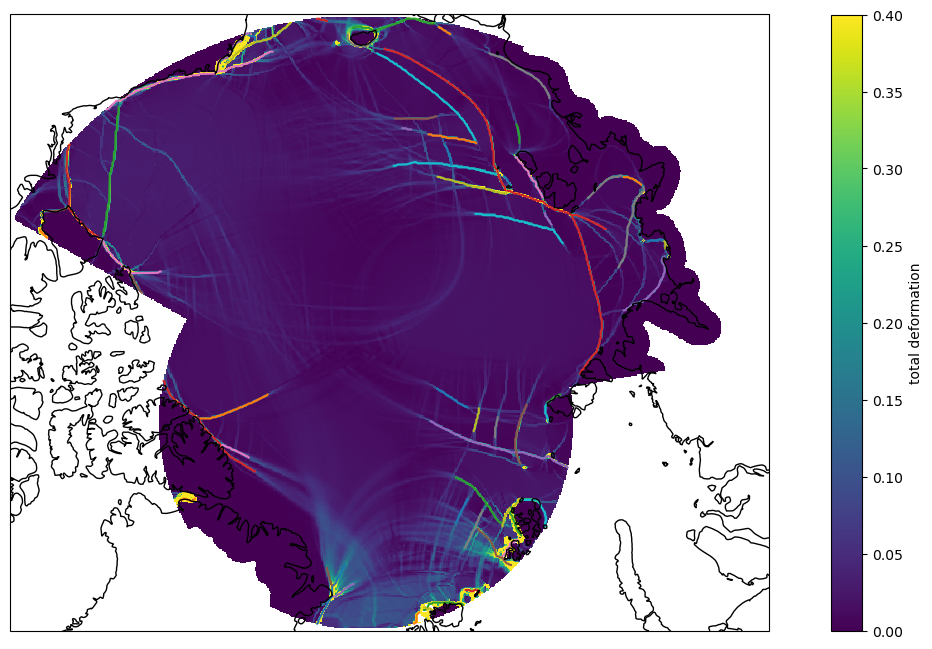

In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=[16, 8])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

ax.coastlines(zorder=3)

pcm = ax.pcolormesh(lkf_data.lon[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                       max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
              lkf_data.lat[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                       max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
              lkf_data.calc_eps_tot(it),axis=0),transform=ccrs.PlateCarree(),vmin=0,vmax=0.4)

it = lkf_data.indexes[-1]

lkfs = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+1))),allow_pickle=True)

for ilkf in lkfs:
    if np.min(ilkf[:,2])<-150 and np.max(ilkf[:,2]>150):
        ilkf[ilkf[:,2]<0,2]+=360
    ax.plot(ilkf[:,2],ilkf[:,3],transform=ccrs.PlateCarree())

plt.colorbar(pcm,label='total deformation')

### Track LKFs

After detecting LKFs, we can track LKFs using the drift fields to advect features. Since we only detected two time steps, we can just track the first pair, which we define with `indexes` again.

In [16]:
%%time
lkf_data.track_lkfs(indexes=[0])

CPU times: user 1.76 ms, sys: 166 µs, total: 1.93 ms
Wall time: 6.73 ms


After tracking the features, we will plot the tracked results to see if it worked appropriately.

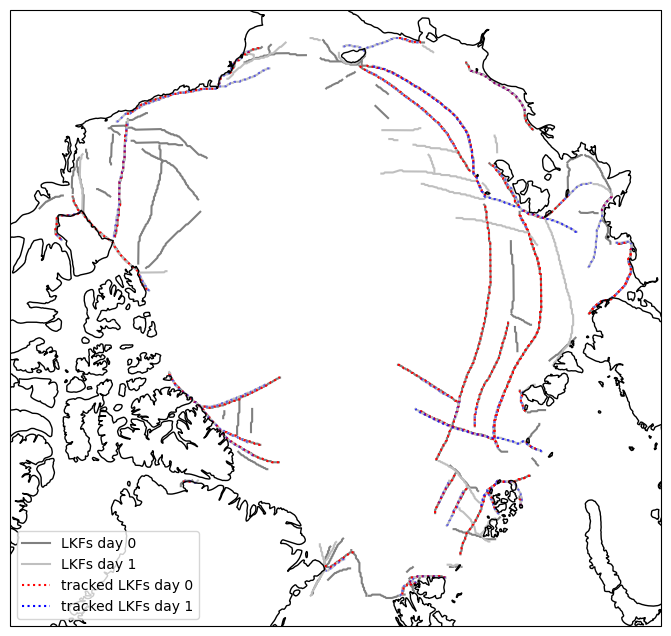

In [35]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=[16, 8])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

ax.coastlines(zorder=3)

it = 0

lkfs0 = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+1))),allow_pickle=True)
lkfs1 = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+2))),allow_pickle=True)

tracks = np.load(lkf_data.track_output_path.joinpath('lkf_tracked_pairs_%s_to_%s.npy' %(lkf_data.lkf_filelist[it][4:-4],
                                                                                        lkf_data.lkf_filelist[it+1][4:-4])),allow_pickle=True)

for ilkf in lkfs0:
    if np.min(ilkf[:,2])<-150 and np.max(ilkf[:,2]>150):
        ilkf[ilkf[:,2]<0,2]+=360
    ax.plot(ilkf[:,2],ilkf[:,3],'0.5',transform=ccrs.PlateCarree())
    
for ilkf in lkfs1:
    if np.min(ilkf[:,2])<-150 and np.max(ilkf[:,2]>150):
        ilkf[ilkf[:,2]<0,2]+=360
    ax.plot(ilkf[:,2],ilkf[:,3],'0.75',transform=ccrs.PlateCarree())

for itrack in tracks:
    ax.plot(lkfs0[itrack[0]][:,2],lkfs0[itrack[0]][:,3],'r:',alpha=1,transform=ccrs.PlateCarree())
    ax.plot(lkfs1[itrack[1]][:,2],lkfs1[itrack[1]][:,3],'b:',alpha=0.5,transform=ccrs.PlateCarree())

    
ax.plot([0,0],[0,0],'0.5',label='LKFs day 0')
ax.plot([0,0],[0,0],'0.75',label='LKFs day 1')
ax.plot([0,0],[0,0],'r:',label='tracked LKFs day 0')
ax.plot([0,0],[0,0],'b:',label='tracked LKFs day 1')

ax.legend()